https://arxiv.org/pdf/2110.01368.pdf

https://arxiv.org/pdf/1911.03380.pdf

https://deliverypdf.ssrn.com/delivery.php?ID=773124118097097119026017080102079065057081049043000029071005117069008065110098087085056017039010001111005112084088095103006007043087058092007068069090091015080092022071021048008071122094090110120127079071113126114121118104123004007070096119111104095125&EXT=pdf&INDEX=TRUE

Let $\Sigma_t$ denote portfolio of the instruments under our managment
$$\Sigma_t = n_i(t) \cdot I_i(t),$$
where $n_i(t)$ -- position in the instrument $i$, $I_i(t)$ -- its present value

$$\dot\Sigma(t) = \dot n_i I_i + n_i \dot I_i$$

So we must implement Instruments' dynamics and portolio strategy to control $n_i$ 

In [1]:
import numpy as np
import pandas as pd
from LPtools.utils import Adapter
from LPtools.clients import Client
from LPtools.instruments import UniPool, Bond, Portfolio, Position, Cash, Holder

In [2]:
zcurve = pd.read_csv('zcyc_rates.csv', index_col=0, parse_dates=True, infer_datetime_format=True, na_filter=False)

adapter = Adapter(pool_id="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
                  symbol="ETHUSDT",
                  zcurve=zcurve)

response = adapter(100)

In [2]:
response = pd.read_csv('saved_response.csv', index_col=0, infer_datetime_format=True)

In [3]:
runner = response.itertuples()
print(response.shape)
response.head()

(100, 14)


,fundingRate,Open,Volume,date,feesUSD,liquidity,sqrtPrice,token0Price,token1Price,tvlUSD,volumeUSD,relative_price,mark,risk_free_rate
2021-08-23,0.001587,3241.29,2430852.991,1.629677e+09,162011.187199,1.321197e+19,1.374390e+33,3323.068541,0.000301,1.472374e+08,3.240224e+08,1.104278e+07,3241.190000,6.42
2021-08-24,0.001189,3323.00,2520587.128,1.629763e+09,196604.907005,1.275388e+19,1.406044e+33,3175.128922,0.000315,1.457254e+08,3.932098e+08,1.008144e+07,3323.010000,6.43
2021-08-25,0.000465,3173.99,2405504.816,1.629850e+09,194457.274305,1.816751e+19,1.394881e+33,3226.152108,0.000310,1.522418e+08,3.889145e+08,1.040806e+07,3173.980000,6.39
2021-08-26,0.000300,3227.90,2360877.641,1.629936e+09,191172.517182,1.370694e+19,1.423204e+33,3099.022574,0.000323,1.449578e+08,3.823450e+08,9.603941e+06,3228.210000,6.45
2021-08-27,0.000300,3093.81,2227370.879,1.630022e+09,172471.174069,2.433403e+19,1.385700e+33,3269.043498,0.000306,1.518801e+08,3.449423e+08,1.068665e+07,3092.993934,6.44


In [4]:
init_state = next(runner)

In [5]:
L = UniPool.liquidity_from_mv(init_state, 1000)
L # initial liquidity

8.673619270845231

In [6]:
cash = Cash(0)

pool = Position(tag='pool', instrument=UniPool(L , price_lower=2000, price_upper=5000, fees=.005), last_value=1000)
bond = Position(tag='bond', instrument=Bond(init_state))

cash += pool.rebalance(1) + bond.rebalance(-1000) # create positions, suffer transaction costs

positions = [pool, bond]
balancer = Holder(positions)
portfolio = Portfolio(balancer, cash=cash, positions=positions)

In [12]:
portfolio.rollout(runner)

In [13]:
portfolio.summary

pool_last_val = 224.57040143079385
bond_last_val = -1017.8101686636718
total_value = -813.2397672328589


,pool,bond,payments,transaction_costs
0,200.118622,1.000000,1.337065e-13,0
1,201.682572,1.000178,9.283872e-14,0
2,197.668086,1.000357,1.209721e-13,0
3,202.949538,1.000535,6.147562e-14,0
4,202.234062,1.000714,4.086641e-14,0
...,...,...,...,...
94,219.173371,1.016903,2.854898e-13,0
95,219.915147,1.017084,1.251463e-13,0
96,222.134862,1.017266,1.358600e-13,0
97,223.428204,1.017447,1.052120e-13,0


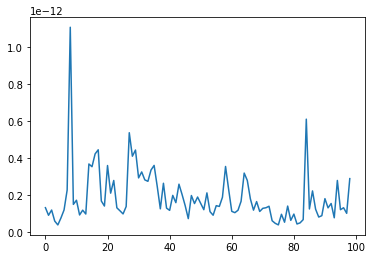

In [19]:
import matplotlib.pyplot as plt
plt.plot(cash.payments[:-1])

In [20]:
np.sum(cash.payments[:-1])

1.8998416792207254e-11